In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(patchwork))
library(parallel)
library(data.table)
library(cowplot)
library(ggsci)
library(aplot)
options(warn=-1)


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots




# MAST

In [5]:
DEG_FILES<-list.files(path = "05B_MAST_BR1_VS_BR2/", pattern = ".csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [6]:
DT<-read.csv(DEG_FILES[1],check.names=FALSE)

ERROR: Error in file(file, "rt"): invalid 'description' argument


In [ ]:
library(stringr)

In [ ]:
 str_extract(DEG_FILES[1], "(?<=-)(.*?)(?=\\.csv)")

In [ ]:
de_list<-mclapply(DEG_FILES,function(i){
DT<-read.csv(i,check.names=FALSE)
DT$celltype<- str_extract(i, "(?<=//)(.*?)(?=-Flu)")
DT$timepoint<- str_extract(i, "(?<=-)(.*?)(?=\\.csv)")

print(gsub(".csv","",unlist(strsplit(unlist(strsplit(i,"//"))[2],"_"))[2]))
result <- merge(data.table(DT)[contrast=='cohort.cohortGuidBR2' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                     data.table(DT)[contrast=='cohort.cohortGuidBR2' & component=='logFC', .(primerid, coef,celltype,timepoint)],
                     by='primerid')
result[,coef:=result[,coef]/log(2)]
result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
    
},mc.cores=60)

In [ ]:
res_all<-do.call(rbind,de_list)
colnames(res_all)<-c('Gene','Pr(>Chisq)','log2FoldChange','celltype','timepoint','padj')

In [ ]:
res_Y1DO<-res_all %>% filter(timepoint=="Flu_Year_2_Day_90")

In [ ]:
selected_celltype<-unique(res_Y1DO$celltype)

In [ ]:
Plot_list<-list()
for (i in 1:length(selected_celltype)){

data <- res_Y1DO %>% filter(celltype==selected_celltype[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))
top <- 15
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[i]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size = 2/5) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated"="dodgerblue3", "Unchanged"="gray50", "Up-regulated"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = Gene),
                   size = 4)+ ggtitle(selected_celltype[i])+theme_classic()+ theme(legend.position = "none")
}

In [ ]:
options(repr.plot.width = 25, repr.plot.height = 25)

wrap_plots(Plot_list)+ guides(colour = "colorbar",size = "none")

In [ ]:
freq <- res_Y1DO %>% filter(celltype%in% selected_celltype)%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  group_by(celltype,Expression) %>%
  summarise(count = n())
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated"~-count,TRUE~count))

In [ ]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

In [ ]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +
  labs(x = "celltype", y = "DEG_Frequency") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

In [ ]:
total_gene <- res_all %>% filter(celltype%in% selected_celltype) %>%
  group_by(celltype) %>%
  summarise(count = n())
total_gene$celltype<-factor(total_gene$celltype,levels=orders)

In [ ]:
p2<-ggplot(total_gene, aes(x = celltype, y = count)) +
  geom_bar(stat = "identity", position = "identity") +
  labs(x = "celltype", y = "Total_Genes_Expressed")+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ylab('N_Genes')

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 6)

p2/p1

# Deseq2-Age control with Sex/CMV

In [2]:
levels='L3'
file_list<-list.files(path = paste0("./02B_DESeq2_BR1_VS_BR2_",levels), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [3]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [4]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [5]:
DEG_sub<-DEG %>% filter(!Expression=="Unchanged")

In [6]:
selected_celltype<-unique(DEG$celltype)


In [7]:
Plot_list<-list()
for (i in 1:length(selected_celltype)){

data <- DEG %>% filter(celltype==selected_celltype[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged"))
top <- 20
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated-BR1') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated-BR1') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[selected_celltype[i]]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size =0.1) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated-BR1"="dodgerblue3", "Unchanged"="gray50", "Up-regulated-BR1"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=8))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = X),
                   size = 3)+ ggtitle(selected_celltype[i])+theme_bw(base_size=11)

}

In [8]:
length(Plot_list)

[1] 71

In [9]:
options(repr.plot.width = 30, repr.plot.height = 70)

P<-wrap_plots(Plot_list,ncol=5)+ plot_layout(guides = "collect")

ggsave(paste0('Deseq2_Volcano_Age_cSEX_cCMV',levels,'.pdf'),width=30,height=70,limitsize = FALSE)

In [10]:
freq <- DEG %>% filter(celltype%in% selected_celltype)%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  group_by(celltype, Expression) %>%
  summarise(count = n())
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-BR1"~-count,TRUE~count))

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


In [11]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

In [12]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

In [13]:
total_gene <- DEG %>% filter(celltype%in% selected_celltype) %>%
  group_by(celltype) %>%
  summarise(count = n())
total_gene$celltype<-factor(total_gene$celltype,levels=orders)

In [14]:
p2<-ggplot(total_gene, aes(x = celltype, y = count)) +
  geom_bar(stat = "identity", position = "identity") +
  labs(x = "celltype", y = "Total_Genes_Expressed")+theme_bw(base_size=12)+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ylab('N_Genes')

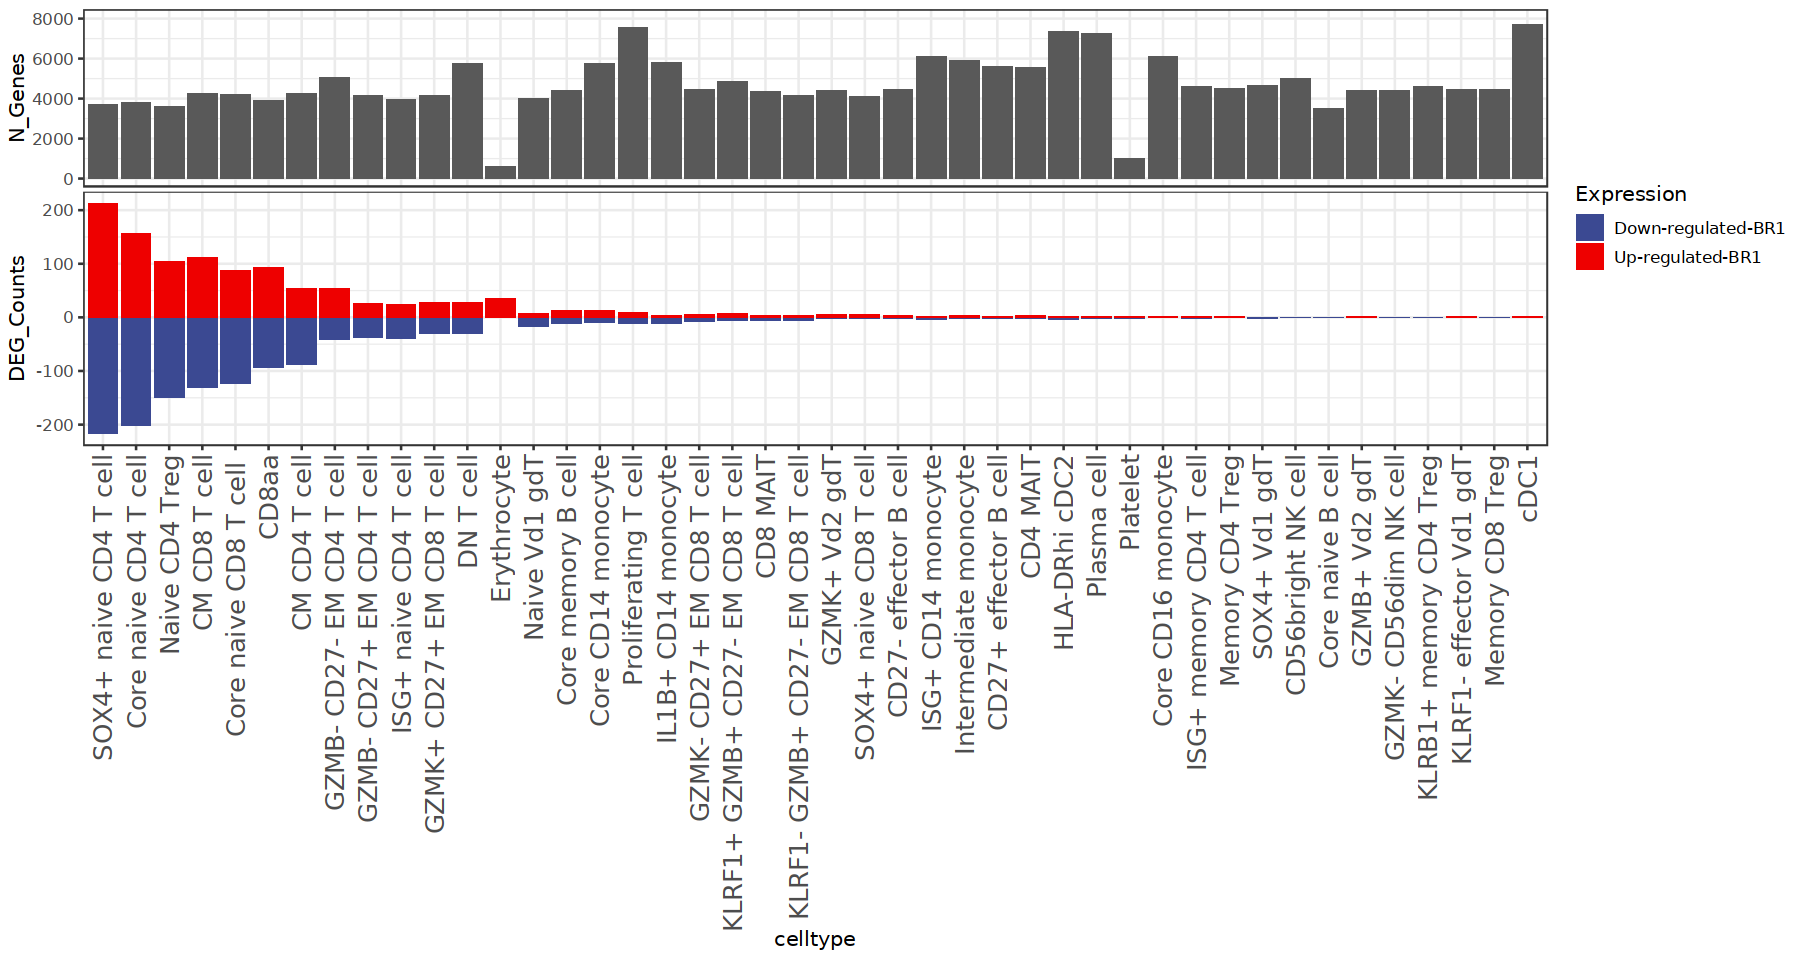

In [15]:
options(repr.plot.width = 15, repr.plot.height = 8)

p3<-p1 %>% insert_top(p2,height=0.7)# %>% as.grob() %>% ggdraw()

p3

ggsave(paste0('Deseq2_Barplot_Age_cSEX_cCMV',levels,'.pdf'),p3,width = 4, height = 3)


In [28]:
freq <- DEG %>%
  filter(celltype %in% selected_celltype) %>%
  mutate(Expression = case_when(
    log2FoldChange >= 0.1 & padj <= 0.1 ~ "Up-regulated-BR1",
    log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated-BR1",
    TRUE ~ "Unchanged"
  )) %>%
  group_by(celltype, Expression) %>%
  summarise(count = n(), .groups = "drop") %>%
  complete(celltype, Expression, fill = list(count = 0))

In [31]:
freq<-freq %>% filter(!Expression=='Unchanged')

In [36]:
freq<-freq%>%
  group_by(celltype) %>%
  summarise(
    TotalCount = sum(count),
  ) %>% arrange(desc(TotalCount))

In [38]:
write.csv(freq ,'DEG_number_Age.csv')

# Deseq2-CMV control with Sex/Age

In [38]:
levels='L3'
file_list<-list.files(path = paste0("./02B_DESeq2_CMVpos_VS_CMVneg_",levels), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)

In [39]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

In [40]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

In [41]:
selected_celltype<-unique(DEG$celltype)

In [42]:
Plot_list<-list()
for (i in 1:length(selected_celltype)){

data <- DEG %>% filter(celltype==selected_celltype[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <= 0.1 ~ "Up-regulated-CMVpos",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated-CMVpos",
                                                     TRUE ~ "Unchanged"))
top <- 20
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated-CMVpos') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated-CMVpos') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[selected_celltype[i]]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size =0.1) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated-CMVpos"="dodgerblue3", "Unchanged"="gray50", "Up-regulated-CMVpos"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=8))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = X),
                   size = 3)+ ggtitle(selected_celltype[i])+theme_bw(base_size=11)

}

In [43]:
length(Plot_list)

[1] 71

In [44]:
options(repr.plot.width = 30, repr.plot.height = 70)

P<-wrap_plots(Plot_list,ncol=5)+ plot_layout(guides = "collect")

ggsave(paste0('Deseq2_Volcano_CMV_cSEX_cAge_',levels,'.pdf'),width=30,height=70,limitsize = FALSE)

In [45]:
freq <- DEG %>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-CMVpos",
                                                     log2FoldChange <= -0.1 & padj <=  0.05~ "Down-regulated-CMVpos",
                                                     TRUE ~ "Unchanged")) %>%
  group_by(celltype, Expression) %>%
  summarise(count = n(), .groups = 'drop') %>%
  # Adding complete() to include zero counts
  complete(celltype, Expression, fill = list(count = 0))%>% filter(!Expression=='Unchanged')
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-CMVpos"~-count,TRUE~count))

In [46]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

In [47]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

In [48]:
total_gene <- DEG %>% filter(celltype%in% selected_celltype) %>%
  group_by(celltype) %>%
  summarise(count = n())
total_gene$celltype<-factor(total_gene$celltype,levels=orders)

In [49]:
p2<-ggplot(total_gene, aes(x = celltype, y = count)) +
  geom_bar(stat = "identity", position = "identity") +
  labs(x = "celltype", y = "Total_Genes_Expressed")+theme_bw(base_size=12)+
  theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())+ylab('N_Genes')

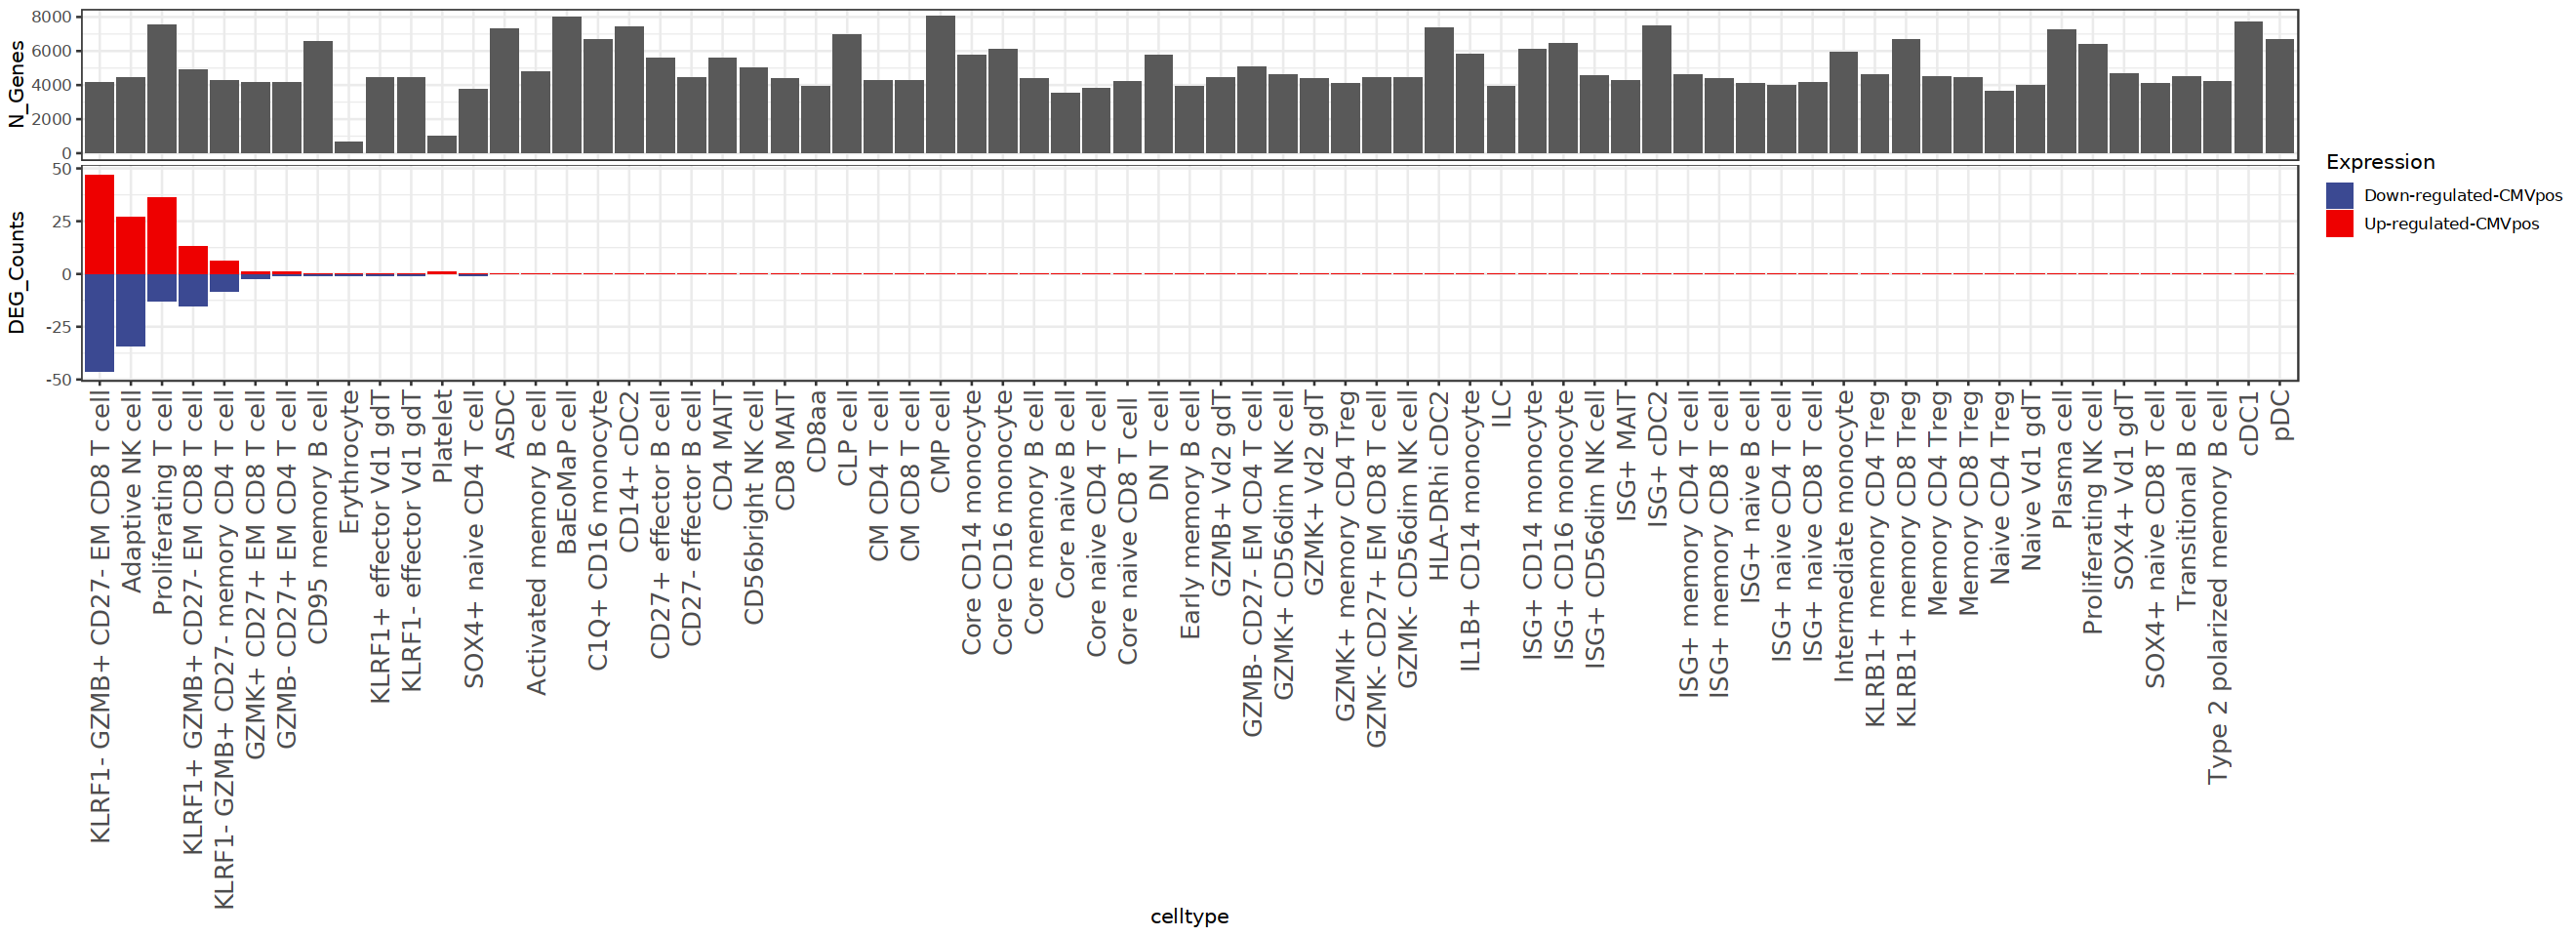

In [50]:
options(repr.plot.width = 22, repr.plot.height = 8)

p3<-p1 %>% insert_top(p2,height=0.7)# %>% as.grob() %>% ggdraw()

p3

ggsave(paste0('Deseq2_Barplot_CMV_cSEX_cAge_',levels,'.pdf'),p3,width = 4, height = 3)


# Deseq2-Age control with Sex on CMVpos and CMVneg

### CMV-Positive

In [1]:
levels='L3'
file_list<-list.files(path = paste0(".//02B_DESeq2_BR1_VS_BR2_",levels,"_on_CMVpos"), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)


In [2]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

ERROR: Error in mclapply(file_list, read.csv, mc.cores = length(file_list)): could not find function "mclapply"


In [3]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

ERROR: Error in DEG %>% mutate(Expression = case_when(log2FoldChange >= 0.1 & : could not find function "%>%"


In [4]:
selected_celltype<-unique(DEG$celltype)

ERROR: Error in eval(expr, envir, enclos): object 'DEG' not found


In [5]:
Plot_list<-list()
for (i in 1:length(selected_celltype)){

data <- DEG %>% filter(celltype==selected_celltype[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged"))
top <- 20
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated-BR1') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated-BR1') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[selected_celltype[i]]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size =0.1) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated-BR1"="dodgerblue3", "Unchanged"="gray50", "Up-regulated-BR1"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=8))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = X),
                   size = 3)+ ggtitle(selected_celltype[i])+theme_bw(base_size=11)

}


ERROR: Error in eval(expr, envir, enclos): object 'selected_celltype' not found


In [6]:
length(Plot_list)

[1] 0

In [7]:
options(repr.plot.width = 30, repr.plot.height = 70)

P<-wrap_plots(Plot_list,ncol=5)+ plot_layout(guides = "collect")

ggsave(paste0('Deseq2_Volcano_Age_cSEX_on_CMVpos_',levels,'.pdf'),width=30,height=70,limitsize = FALSE)

ERROR: Error in wrap_plots(Plot_list, ncol = 5): could not find function "wrap_plots"


In [8]:
freq <- DEG %>% filter(celltype%in% selected_celltype)%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <= 0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  group_by(celltype, Expression) %>%
  summarise(count = n())
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-BR1"~-count,TRUE~count))

ERROR: Error in DEG %>% filter(celltype %in% selected_celltype) %>% mutate(Expression = case_when(log2FoldChange >= : could not find function "%>%"


In [9]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

ERROR: Error in eval(expr, envir, enclos): object 'freq' not found


In [10]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

ERROR: Error in eval(expr, envir, enclos): object 'freq' not found


In [11]:
freq_CMVpos<-freq
freq_CMVpos['CMV_Group']<-'Positive'

ERROR: Error in eval(expr, envir, enclos): object 'freq' not found


### CMV-Negative

In [12]:
levels='L3'
file_list<-list.files(path = paste0(".//02B_DESeq2_BR1_VS_BR2_",levels,"_on_CMVneg"), pattern = ".csv", all.files = FALSE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = FALSE, include.dirs = TRUE, no.. = FALSE)


In [13]:
DEG_list<-mclapply(file_list,read.csv,mc.cores=length(file_list))
DEG<-do.call(rbind,DEG_list)

ERROR: Error in mclapply(file_list, read.csv, mc.cores = length(file_list)): could not find function "mclapply"


In [14]:
DEG<- DEG%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated",
                                                     TRUE ~ "Unchanged"))

ERROR: Error in DEG %>% mutate(Expression = case_when(log2FoldChange >= 0.1 & : could not find function "%>%"


In [15]:
selected_celltype<-unique(DEG$celltype)

ERROR: Error in eval(expr, envir, enclos): object 'DEG' not found


In [16]:
Plot_list<-list()
for (i in 1:length(selected_celltype)){

data <- DEG %>% filter(celltype==selected_celltype[i])%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged"))
top <- 20
top_genes <- bind_rows(
  data %>% 
    filter(Expression == 'Up-regulated-BR1') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top),
  data %>% 
    filter(Expression == 'Down-regulated-BR1') %>% 
    arrange(padj, desc(abs(log2FoldChange))) %>% 
    head(top)
)
    
Plot_list[[selected_celltype[i]]]<-ggplot(data, aes(log2FoldChange, -log(padj,10))) +
  geom_point(aes(color = Expression), size =0.1) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"FDR")) +
  scale_color_manual(values = c("Down-regulated-BR1"="dodgerblue3", "Unchanged"="gray50", "Up-regulated-BR1"="firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=8))) +
  geom_text_repel(data = top_genes,box.padding = 0.5,force= 0.5,max.overlaps=15,
    nudge_x           = 0.15,
    hjust             = 0.1,
    segment.size      = 0.1,
                   mapping = aes(log2FoldChange, -log(padj,10), label = X),
                   size = 3)+ ggtitle(selected_celltype[i])+theme_bw(base_size=11)

}


ERROR: Error in eval(expr, envir, enclos): object 'selected_celltype' not found


In [67]:
length(Plot_list)

[1] 71

In [68]:
options(repr.plot.width = 30, repr.plot.height = 70)

P<-wrap_plots(Plot_list,ncol=5)+ plot_layout(guides = "collect")

ggsave(paste0('Deseq2_Volcano_Age_cSEX_on_CMVneg_',levels,'.pdf'),width=30,height=70,limitsize = FALSE)

In [69]:
freq <- DEG %>% filter(celltype%in% selected_celltype)%>% mutate(Expression = case_when(log2FoldChange >=0.1 & padj <=  0.05 ~ "Up-regulated-BR1",
                                                     log2FoldChange <= -0.1 & padj <=  0.05 ~ "Down-regulated-BR1",
                                                     TRUE ~ "Unchanged")) %>% filter(!Expression=='Unchanged')%>%
  group_by(celltype, Expression) %>%
  summarise(count = n())
freq<-freq %>% mutate (count=case_when(Expression=="Down-regulated-BR1"~-count,TRUE~count))

`summarise()` has grouped output by 'celltype'. You can override using the
`.groups` argument.


In [70]:
orders<-freq
orders$count<-abs(orders$count)
orders<-orders%>%
  group_by(celltype) %>%
  summarize(value = sum(count))%>%arrange(desc(value)) %>% select (celltype) %>% pull()

In [71]:
options(repr.plot.width = 10, repr.plot.height = 5)
#orders<-unique(freq %>% arrange(desc(count)) %>% select (celltype) %>% pull())
freq$celltype<-factor(freq$celltype,levels=orders)
p1<-ggplot(freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))

In [72]:
freq_CMVneg<-freq
freq_CMVneg['CMV_Group']<-'Negative'

#### combined barplots

In [73]:
combined_freq<-rbind(as.data.frame(ungroup(freq_CMVpos)),as.data.frame(ungroup(freq_CMVneg)))

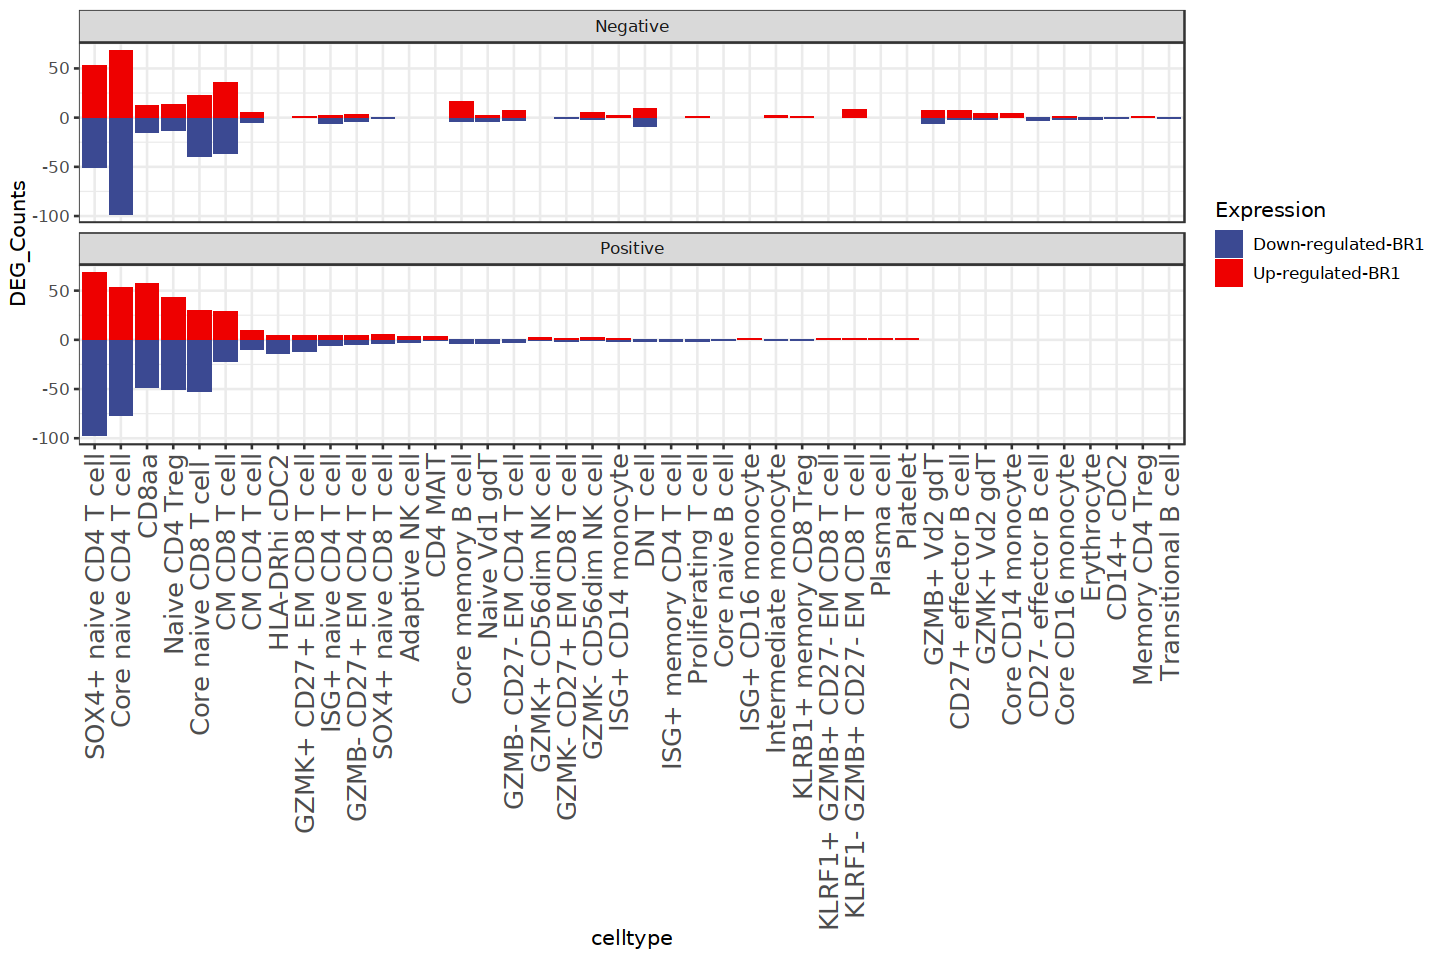

In [74]:
options(repr.plot.width = 12, repr.plot.height = 8)

p1<-ggplot(combined_freq, aes(x = celltype, y = count, fill = Expression)) +
  geom_bar(stat = "identity", position = "identity") +theme_bw(base_size=12)+  scale_fill_aaas()+
  labs(x = "celltype", y = "DEG_Counts") +  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 15))
p1+facet_wrap(~CMV_Group,ncol=1)